In [147]:
# -*- coding: utf-8 -*-
# Importations
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import os
import json 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import psycopg2 as pg
import scipy.special
import pandas_profiling
from pandas.plotting import lag_plot
from bokeh.io import output_file, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.palettes import all_palettes
from bokeh.plotting import figure
from bokeh.models import Band, ColumnDataSource

In [2]:
fct_haemo = pd.read_csv('../data/model/fct_haemodynamic.csv',index_col=0)
fct_haemo['id_patient'] = fct_haemo['id_patient'].astype(int)
fct_haemo['dc'] = fct_haemo['dc'].astype(float)
fct_haemo['fc'] = fct_haemo['fc'].astype(float)
fct_haemo['papdia'] = fct_haemo['papdia'].astype(float)
fct_haemo['papmoy'] = fct_haemo['papmoy'].astype(float)
fct_haemo['papsys'] = fct_haemo['papsys'].astype(float)
fct_haemo['pasd'] = fct_haemo['pasd'].astype(float)
fct_haemo['pasm'] = fct_haemo['pasm'].astype(float)
fct_haemo['pass'] = fct_haemo['pass'].astype(float)
fct_haemo['pnid'] = fct_haemo['pnid'].astype(float)
fct_haemo['pnim'] = fct_haemo['pnim'].astype(float)
fct_haemo['pnis'] = fct_haemo['pnis'].astype(float)

In [3]:
pandas_profiling.ProfileReport(fct_haemo).to_file(outputfile="fct_haemo_profiling.html")

In [4]:
dim_patient = pd.read_csv('../data/dim_patient.csv')

In [82]:
df = pd.merge(fct_haemo, dim_patient[['id_patient','date_transplantation']], on='id_patient')
df['timestamp'] = df['date_transplantation'] + '-' +df['time']
df = df[df['time'] != '0']
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
#https://machinelearningmastery.com/time-series-data-visualization-with-python/

# Plotting time series for one patient

In [23]:
df_melt = pd.melt(df, id_vars=['id_patient','timestamp'], value_vars=['dc','fc','papdia','papmoy','papsys','pasd','pasm','pass','pnid','pnim','pnis'])

In [73]:
def plot_haemodynamic(id_patient):
    print('Displaying haemodynamic measures for patient # {}'.format(id_patient))
    g = sns.FacetGrid(df_melt[df_melt_bornes['id_patient'] == id_patient], col="variable", col_wrap=4, sharey=False)
    g = g.map(plt.plot, "timestamp", "value")

Displaying haemodynamic measures for patient # 400


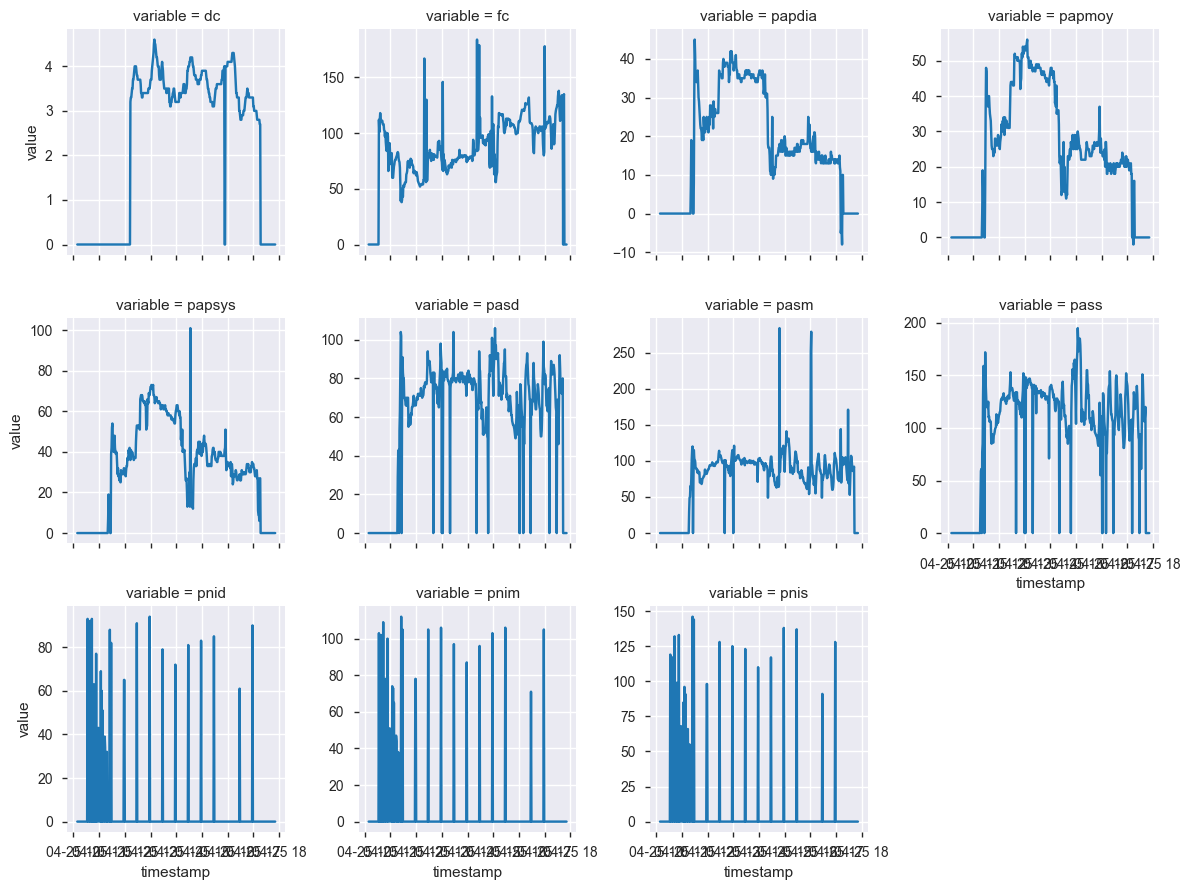

In [74]:
plot_haemodynamic(400)

In [ ]:
#TODO : récupérer les seuils avec ça et les plotter sur les time series https://github.com/dataforgoodfr/batch_5_transplant/blob/exploration/notebook/CBAC/first-insight.ipynb

# Time series features extraction (from Clément)

In [33]:
def features_cat(df , path = "features.json") : 
    
    rules = get_json(path)
    for r in rules.keys() :
        
        try : 
            
            cond_str = get_conditions(rules[r])
            q = 'df["{}"] = df["{}"].map(lambda x : {})'.format(r, rules[r]["name"], cond_str)
            exec(q)
        except : 
            print("could not create columns {}".format(rules[r]["name"]))
            pass
        
    return(df)

def get_conditions(conditions):
    
    cond = str()
    for i in conditions["conditions"].keys():
        
        cond = cond + "{} if   {}  else ".format('"' + conditions["conditions"][i]  + '"' , i )

    cond = cond + '"unknown"'
    return(cond)

def get_json(path = "features.json") : 
    
    f = json.load(open(path))
    
    return(f)

def features_cat(df , dataset_name, path = "features_haemodynamic.json") : 


    conditions = get_json(path)
    
    for i in conditions.keys():
        
        cond = get_conditions(conditions[i])    
        name_new_col = conditions[i]['name']
        col = i

        q = '{}["{}"] = {}["{}"].map(lambda x : {})'.format(dataset_name , name_new_col, dataset_name ,  col , cond)
    
        exec(q)
    

def get_conditions(conditions) :

    q1 = " 'normal' if x >= {}  and  x <= {} else  " .format(conditions['normalite'][0], conditions['normalite'][1])
    q2 = " 'anormal' if x > {} and x < {} else ".format(conditions['etendue'][0], conditions['normalite'][0])
    q3 = "'anormal' if x > {} and x < {} else ".format(conditions['normalite'][1], conditions['etendue'][1])
    q4 = " 'dirty' if x < {} and x > {} else ".format(conditions['etendue'][0], conditions['etendue'][1])
    q5 = "'null' if x == 0 else 'unkown'"
    
    
    
    cond = q1 + q2 + q3 + q4 + q5
    
    #print(cond)
    
    return(cond)

In [76]:
df_featurescat = features_cat(df, 'df', 'features_haemodynamic.json')

# Plotting time series with normality thresholds for one patient

In [152]:
def get_cond(path):
    cond = pd.read_json(path).transpose()
    
    cond['etendue_min'] = cond['etendue'].map(lambda x: x[0])
    cond['etendue_max'] = cond['etendue'].map(lambda x: x[1])
    cond['norm_min'] = cond['normalite'].map(lambda x: x[0])
    cond['norm_max'] = cond['normalite'].map(lambda x: x[1])
    
    return cond

In [163]:
output_notebook()

def plot_haemodynamic_norm(id_patient, path):
    
    cond = get_cond(path)
        
    df_patient = df[df['id_patient'] == id_patient]
    p_list = []
    j = 0

    for i in cond.index:
        p = figure(plot_width=200, plot_height=200, title=i)
        p.line(df_patient['timestamp'], cond.loc[i,'norm_min'], color='red', line_width=2)
        p.line(df_patient['timestamp'], cond.loc[i,'norm_max'], color='red', line_width=2)
        p.line(df_patient['timestamp'], df_patient[i], color=all_palettes['PuBu'][3][0], line_width=2)
        p.xgrid[0].grid_line_color=None
        p.xaxis.major_label_text_font_size = '0pt'
        p.xaxis.major_tick_line_color = None  
        p.xaxis.minor_tick_line_color = None  
        p.ygrid[0].grid_line_alpha=0.5
        p_list.append(p)
        j+=1

    # make a grid
    grid = gridplot(p_list, ncols=4)

    # show the results
    show(grid)

Loading BokehJS ...

In [164]:
plot_haemodynamic_norm(381, 'features_haemodynamic.json')

# Scatter plot of a time serie to investigate its stationarity

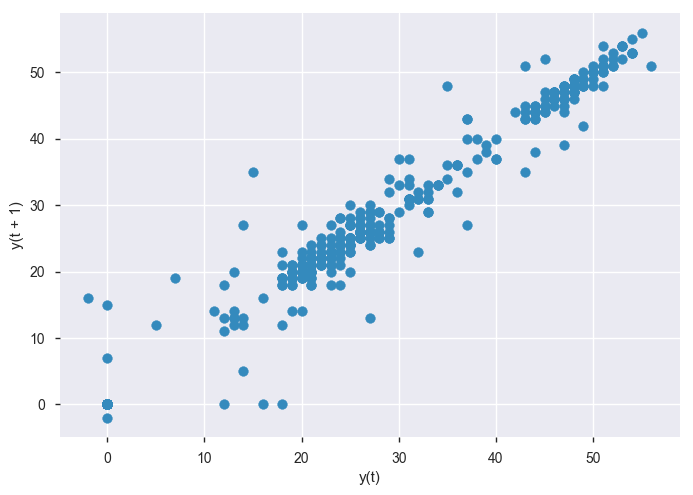

In [26]:
pat = df[df['id_patient'] == 400]
pat = pat.drop(columns=['time','date_transplantation'])
pat['papmoy_shift'] = pat['papmoy'].shift(1)
lag_plot(pat['papmoy'])

# Make a time series stationary with x_t = log(x_t) - log(x_(t-1))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


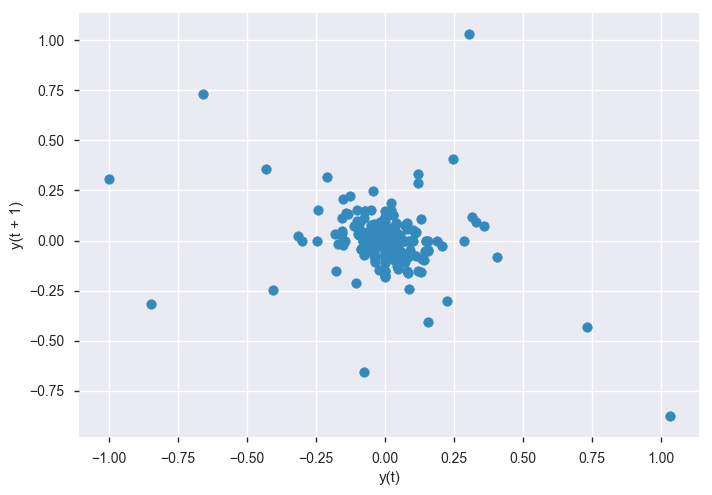

In [27]:
lag_plot(np.log(pat['papmoy_shift']) - np.log(pat['papmoy']))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


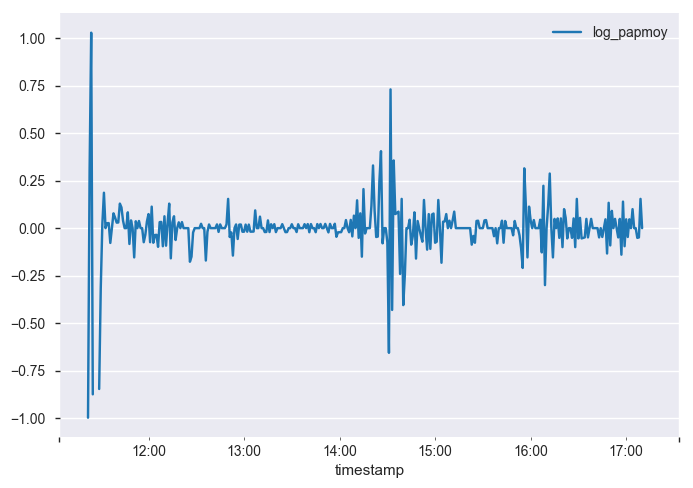

In [28]:
pat['log_papmoy'] = np.log(pat['papmoy_shift']) - np.log(pat['papmoy'])    
pat.plot(y='log_papmoy',x='timestamp')

In [21]:
#pat

In [20]:
df.id_patient.unique()

array([381, 384, 372, 377, 370, 389, 388, 383, 373, 375, 382, 368, 371,
       390, 369, 386, 379, 376, 362, 378, 391, 367, 387, 363, 364, 380,
       366, 392, 329, 323, 316, 301, 326, 311, 330, 319, 328, 314, 312,
       320, 327, 305, 325, 302, 315, 300, 309, 322, 318, 304, 308, 156,
       158, 164, 151, 163, 170, 155, 150, 171, 275, 175, 166, 172, 152,
       159, 168, 154, 153, 160, 167, 157, 161, 174, 219, 210, 232, 217,
       226, 211, 215, 223, 207, 220, 225, 218, 208, 209, 216, 224, 221,
       222, 206, 233, 213, 214, 229, 230, 227, 236, 234, 235, 231, 228,
       349, 351, 333, 354, 347, 357, 338, 346, 358, 109, 344, 359, 361,
       360, 334, 355, 342, 343, 335, 337, 336, 331, 352, 340, 356, 393,
       407, 404, 398, 400, 399, 403, 411, 410, 394, 405, 401, 397, 395,
       408, 409, 406, 396, 259, 239, 272, 267, 248, 265, 251, 245, 270,
       249, 247, 252, 263, 264, 237, 250, 269, 257, 238, 240, 246, 256,
       255, 241, 276, 271, 268, 273, 260, 243, 253, 258, 277, 24